In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [ ]:
# Import Libraries
import tensorflow as tf
import numpy as np

import keras
import pandas as pd
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda, MaxPooling2D
from keras.layers import Resizing, Conv2DTranspose, UpSampling2D, concatenate
from keras.regularizers import l2, l1
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import model_from_json
from keras.optimizers import Adam

from IPython.display import clear_output
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import random

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [ ]:
# Function to save a model
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

def data_random_shuffle(X,y):

  random_order = np.random.permutation(len(X))
  X = X[random_order]
  y = y[random_order]

  return X, y

def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  3539k      0  0:00:04  0:00:04 --:--:-- 3860k
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


In [ ]:
# Load data and create Input Vectors for classifica

for _type in ['benign', 'malignant', 'normal']:

  X0 = np.load(f'/home/tcd/data/medicalimaging/dataset/benign/input.npy')
  y0 = np.zeros([393,1])

  X1 = np.load(f'/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
  y1 = np.full((189,1), fill_value = 1)

  X2 = np.load(f'/home/tcd/data/medicalimaging/dataset/normal/input.npy')
  y2 = np.full((119,1), fill_value = 2)

X_list = (X0,X1,X2)
X = np.concatenate(X_list,axis=0)

Y_list = (y0,y1,y2)
y = np.concatenate(Y_list, axis = 0)
y = keras.utils.to_categorical(y)

X,y = data_random_shuffle(X,y)


In [ ]:
# Create Test/Train Split
X_train, X_validation, y_train, y_validation = skl.model_selection.train_test_split(X, y, test_size=.1)

In [ ]:
# Model 1

inputs = keras.layers.Input(shape=(128, 128, 3))

x = inputs

x = Conv2D(32, (3,3), padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding = 'same', activation='relu',)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding = 'same', activation='relu',)(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer = l2(l=0.01))(x)

predictions = Dense(3, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

if (model.count_params() > 5000000):
    raise Exception("Your model is unecessarily complex, scale down!")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856 

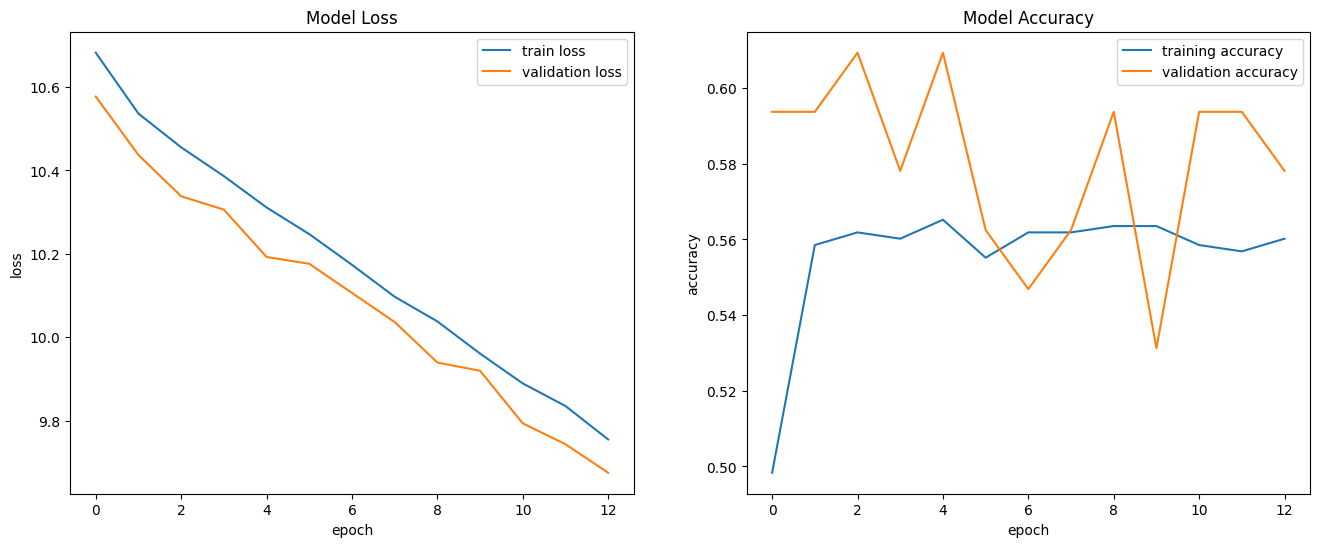

19/19 [==============================] - 3s 147ms/step - loss: 9.7548 - accuracy: 0.5602 - val_loss: 9.6750 - val_accuracy: 0.5781
Epoch 14/75
 8/19 [===========>..................] - ETA: 1s - loss: 9.7170 - accuracy: 0.5508

KeyboardInterrupt: 

In [ ]:
# Augmentation
pltCallBack = PlotLossAccuracy()

train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   )

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size = 32,
                                     )

validation_generator = test_datagen.flow(X_validation,
                                          y_validation,
                                          batch_size = 32,
                                          )


history = model.fit(train_generator,
                    steps_per_epoch = len(X_train)//32,
                    epochs = 75,
                    validation_data = validation_generator,
                    validation_steps =  len(X_validation)//32,
                    callbacks=[pltCallBack],
                   )


In [ ]:
# MODEL 2

inputs = keras.layers.Input(shape=(128, 128, 3))

x = inputs

x = Conv2D(16, (3,3), padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(32, (3,3), padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding = 'same', activation='relu',)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding = 'same', activation='relu',)(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer = l2(l=0.01))(x)

predictions = Dense(3, activation='softmax')(x)

model_2 = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

if (model_2.count_params() > 5000000):
    raise Exception("Your model is unecessarily complex, scale down!")

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        184

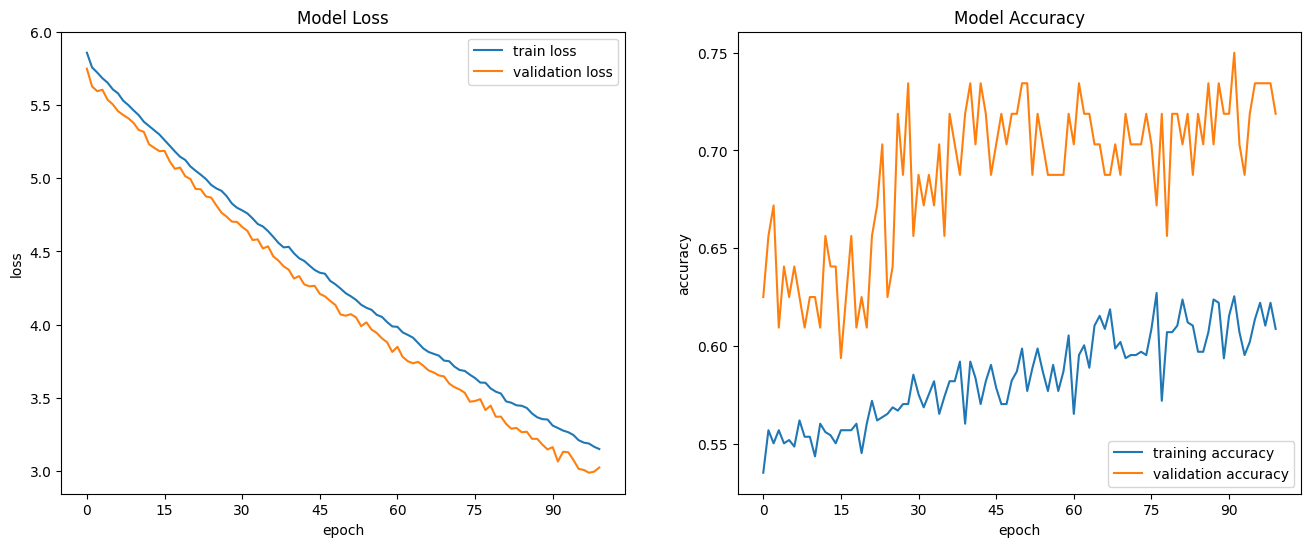

19/19 [==============================] - 3s 138ms/step - loss: 3.1514 - accuracy: 0.6087 - val_loss: 3.0253 - val_accuracy: 0.7188


In [ ]:
# Augmentation
pltCallBack = PlotLossAccuracy()

train_datagen = ImageDataGenerator(
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   )

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size = 32,
                                     )

validation_generator = test_datagen.flow(X_validation,
                                          y_validation,
                                          batch_size = 32,
                                          )


history = model_2.fit(train_generator,
                    steps_per_epoch = len(X_train)//32,
                    epochs = 100,
                    validation_data = validation_generator,
                    validation_steps =  len(X_validation)//32,
                    callbacks=[pltCallBack],
                   )


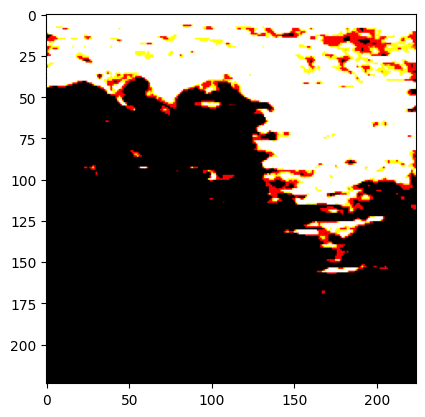

In [ ]:
#Preprocessing for transfer learning

import cv2
import numpy as np

for _type in ['benign', 'malignant', 'normal']:

  X0VGG = np.load(f'/home/tcd/data/medicalimaging/dataset/benign/input.npy')
  y0VGG = np.zeros([393,1])

  X1VGG = np.load(f'/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
  y1VGG = np.full((189,1), fill_value = 1)

  X2VGG = np.load(f'/home/tcd/data/medicalimaging/dataset/normal/input.npy')
  y2VGG = np.full((119,1), fill_value = 2)


XVGG_list = (X0VGG,X1VGG,X2VGG)
XVGG = np.concatenate(XVGG_list,axis=0)


YVGGlist = (y0VGG,y1VGG,y2VGG)
yVGG = np.concatenate(Y_list, axis = 0)
yVGG = keras.utils.to_categorical(yVGG)

XVGG,yVGG = data_random_shuffle(XVGG,yVGG)

target_shape = (224, 224, 3)

def _resize_image(image, target):
   return cv2.resize(image, dsize=(target[0], target[1]), interpolation=cv2.INTER_LINEAR)

X_224 = [_resize_image(image=i, target=target_shape) for i in XVGG]
X_224 = np.stack(X_224, axis=0)

X_224,yVGG = data_random_shuffle(X_224,yVGG)

X_224 = (X_224 * 255).astype('float32')

X_224 = preprocess_input(X_224, data_format=None)

plt.imshow(X_224[1])

X224_train, X224_validation, y224_train, y224_validation = skl.model_selection.train_test_split(X_224, yVGG, test_size=.1)


In [ ]:
# Transfer Learning
base = keras.applications.VGG16(include_top=False, weights="imagenet",input_shape = (224,224,3))
base.trainable = False

inputs = keras.layers.Input(shape=(224,224,3))

x = inputs
x = base(x, training = False)

x = Flatten()(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)

model_VGG16 = keras.models.Model(inputs=inputs, outputs=predictions)

model_VGG16.compile(optimizer = Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_VGG16.summary()

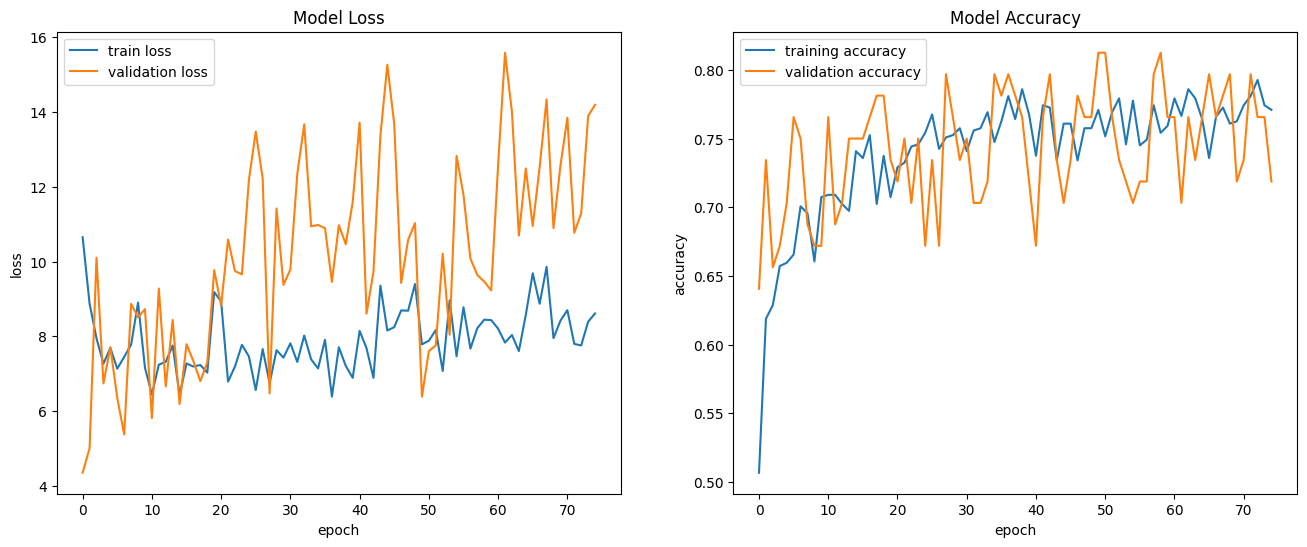

19/19 [==============================] - 7s 365ms/step - loss: 8.6137 - accuracy: 0.7709 - val_loss: 14.1958 - val_accuracy: 0.7188


In [ ]:
# num_epochs = 100

# pltCallBack = PlotLossAccuracy()

# model_VGG16.fit(X224_train, y224_train,
#           batch_size=32, epochs=num_epochs,
#           validation_data=(X224_validation, y224_validation),
#           callbacks=[pltCallBack])

pltCallBack = PlotLossAccuracy()

train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   preprocessing_function=preprocess_input
                                   )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(X224_train,
                                     y224_train,
                                     batch_size = 32,
                                     )

validation_generator = test_datagen.flow(X224_validation,
                                         y224_validation,
                                         batch_size = 32,
                                        )


history = model_VGG16.fit(train_generator,
                    steps_per_epoch = len(X224_train)//32,
                    epochs = 75,
                    validation_data = validation_generator,
                    validation_steps =  len(X224_validation)//32,
                    callbacks=[pltCallBack],
                   )

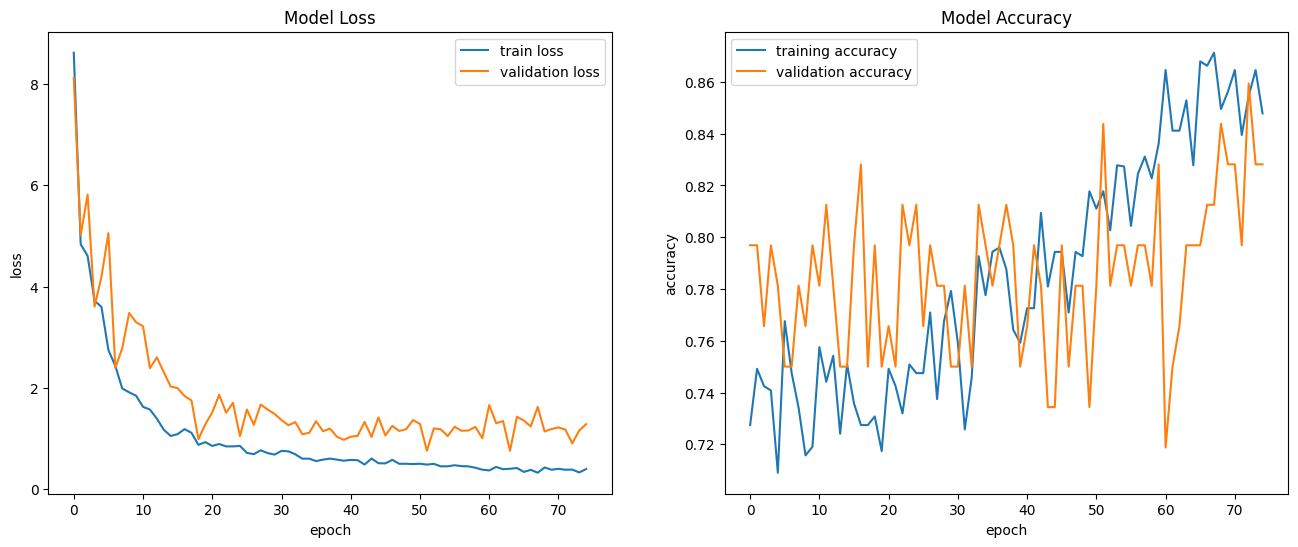

19/19 [==============================] - 9s 448ms/step - loss: 0.3987 - accuracy: 0.8478 - val_loss: 1.2852 - val_accuracy: 0.8281


In [ ]:
# Fine Tuning
base.trainable = True

model_VGG16.compile(optimizer = Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_VGG16.summary()

model_VGG16.fit(
                train_generator,
                steps_per_epoch = len(X224_train)//32,
                epochs = 75,
                validation_data = validation_generator,
                validation_steps =  len(X224_validation)//32,
                callbacks=[pltCallBack],
                )

22/22 [==============================] - 0s 5ms/step
0.419


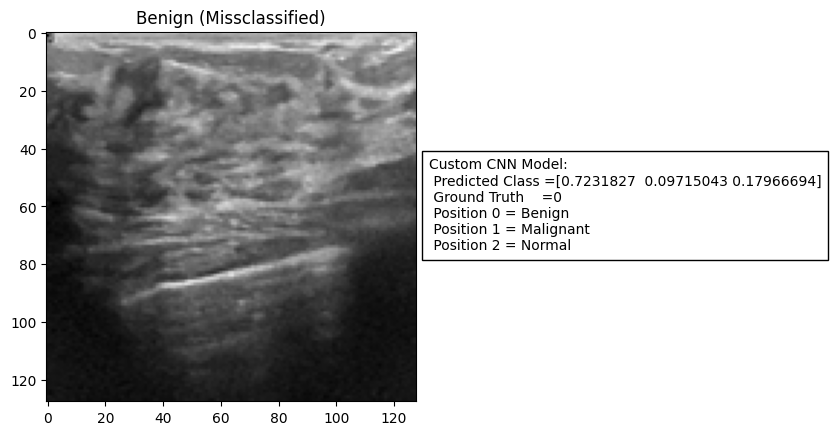

In [ ]:
from sklearn.metrics import f1_score

# Probability of belonging to class:
y_pred = model_2.predict(X)

plt.imshow(X[12][:][:][:])
plt.title("Benign (Missclassified)")
plt.text(132, 75, f'Custom CNN Model:\n Predicted Class ={y_pred[12]}\n Ground Truth    ={y[12]}\n Position 0 = Benign\n Position 1 = Malignant\n Position 2 = Normal', bbox={'facecolor': 'white', 'pad': 5})

y_pred = np.argmax(y_pred, axis=1)

print(np.round(f1_score(y, y_pred, average='macro'),decimals = 3))


In [ ]:
classification_model = model_2
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")


Saved model to model.json and weights to model.h5


In [ ]:
for _type in ['benign', 'malignant', 'normal']:

  X_0 = np.load(f'/home/tcd/data/medicalimaging/dataset/benign/input.npy')
  y_0 = np.load(f'/home/tcd/data/medicalimaging/dataset/benign/target.npy')

  X_1 = np.load(f'/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
  y_1 = np.load(f'/home/tcd/data/medicalimaging/dataset/malignant/target.npy')

  X_2 = np.load(f'/home/tcd/data/medicalimaging/dataset/normal/input.npy')
  y_2 = np.load(f'/home/tcd/data/medicalimaging/dataset/normal/target.npy')

X_Seg_list = (X_0,X_1,X_2)
X_Seg = np.concatenate(X_Seg_list,axis=0)

print(y_1.shape)

Y_Seg_list = (y_0,y_1,y_2)
y_Seg = np.concatenate(Y_Seg_list, axis = 0)
print(y_Seg.shape)
# print(f"unshuffled x  = \n {X} \n unshuffled y {y}")

X_Seg,y_Seg = data_random_shuffle(X_Seg,y_Seg)

# print(f"shuffled x  = \n {X} \n shuffled y {y}")

(189, 128, 128, 1)
(701, 128, 128, 1)


In [ ]:
X_Seg_train, X_Seg_validation, y_Seg_train, y_Seg_validation = skl.model_selection.train_test_split(X_Seg, y_Seg, test_size=.1)

print(y_Seg_train.shape)
print(X_Seg_train.shape)
print(y_Seg_validation.shape)
print(X_Seg_validation.shape)

(630, 128, 128, 1)
(630, 128, 128, 3)
(71, 128, 128, 1)
(71, 128, 128, 3)


In [ ]:
# UNET 1

inputs = keras.layers.Input(shape=(128, 128, 3))

x = inputs

conv1 = Conv2D(16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
conv1 = Conv2D(16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D((2,2))(conv1)

conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D((2,2))(conv2)

conv3 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(64,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D((2,2))(conv3)

conv4 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
pool4 = MaxPooling2D((2,2))(conv4)

conv5 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

# Upsampling

up1 = Conv2DTranspose(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
merge1 = concatenate([up1, conv4], axis = 3)
conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
conv6 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up2 = Conv2DTranspose(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge2 = concatenate([up2, conv3], axis = 3)
conv7 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
conv7 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up3 = Conv2DTranspose(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge3 = concatenate([up3, conv2], axis = 3)
conv8 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
conv8 = Conv2D(32,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up4 = Conv2DTranspose(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge4 = concatenate([up4, conv1], axis = 3)
conv9 = Conv2D(16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
conv9 = Conv2D(16,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

outputs = Conv2D(1, (1,1), activation="sigmoid", padding="same")(conv9)

model_seg = keras.models.Model(inputs=inputs, outputs=outputs)

model_seg.compile(optimizer = "adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_seg.summary()

if (model_seg.count_params() > 3000000):
    raise Exception("Your model is unecessarily complex, scale down!")

In [ ]:
# UNET 2

inputs = keras.layers.Input(shape=(128, 128, 3))

x = inputs

conv1 = Conv2D(8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
conv1 = Conv2D(8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D((2,2))(conv1)

conv2 = Conv2D(16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D((2,2))(conv2)

conv3 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(32,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D((2,2))(conv3)

conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
pool4 = MaxPooling2D((2,2))(conv4)

conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

# Upsampling

up1 = Conv2DTranspose(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
merge1 = concatenate([up1, conv4], axis = 3)
conv6 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
conv6 = Conv2D(64,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up2 = Conv2DTranspose(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge2 = concatenate([up2, conv3], axis = 3)
conv7 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
conv7 = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up3 = Conv2DTranspose(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge3 = concatenate([up3, conv2], axis = 3)
conv8 = Conv2D(16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
conv8 = Conv2D(16,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up4 = Conv2DTranspose(8, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge4 = concatenate([up4, conv1], axis = 3)
conv9 = Conv2D(8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
conv9 = Conv2D(8,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

outputs = Conv2D(1, (1,1), activation="sigmoid", padding="same")(conv9)

model_seg2 = keras.models.Model(inputs=inputs, outputs=outputs)

model_seg2.compile(optimizer = "adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_seg2.summary()

if (model_seg2.count_params() > 3000000):
    raise Exception("Your model is unecessarily complex, scale down!")

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 128, 128, 8)          224       ['input_16[0][0]']            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 128, 128, 8)          584       ['conv2d_59[0][0]']           
                                                                                                  
 max_pooling2d_44 (MaxPooli  (None, 64, 64, 8)            0         ['conv2d_60[0][0]']           
 ng2D)                                                                                     

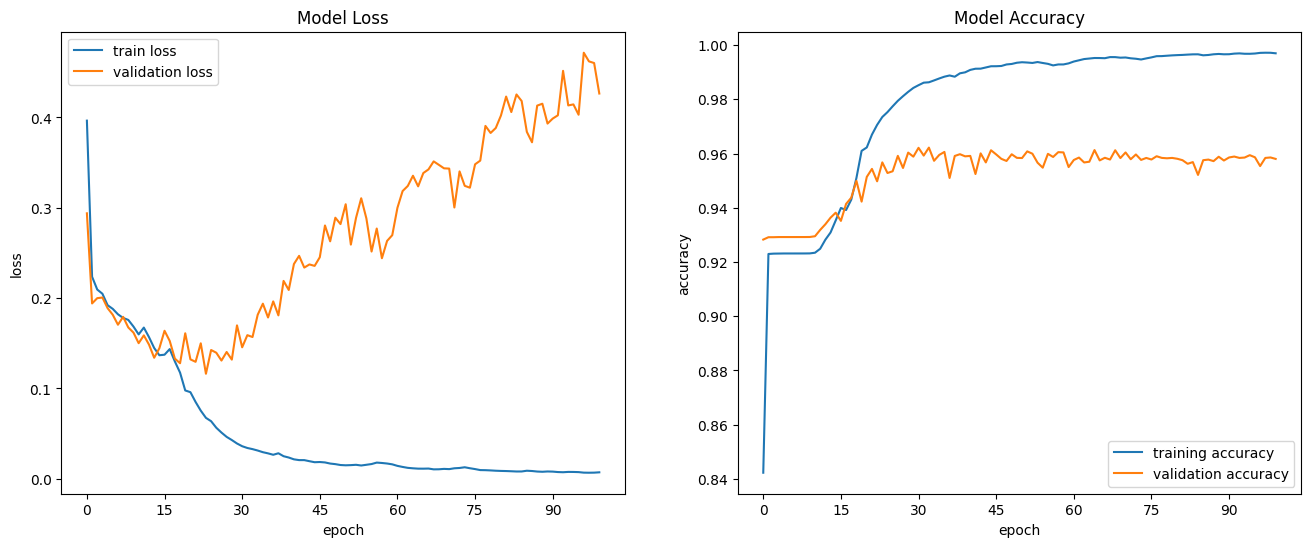

20/20 [==============================] - 1s 67ms/step - loss: 0.0071 - accuracy: 0.9970 - val_loss: 0.4265 - val_accuracy: 0.9580


In [ ]:
pltCallBack = PlotLossAccuracy()

num_epochs = 100

model_seg2.fit(X_Seg_train, y_Seg_train,
          batch_size=32, epochs=num_epochs,
          validation_data = (X_Seg_validation, y_Seg_validation),
          callbacks=[pltCallBack])

22/22 [==============================] - 0s 17ms/step
F1 Score = 0.96


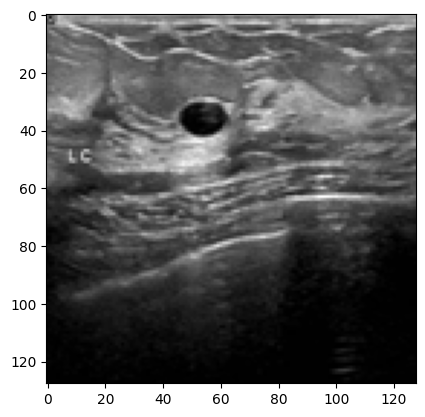

In [ ]:
seg_predicted = model_seg2.predict(X_Seg)
fig1 = plt.imshow(X_Seg[500])

conv1 = Dropout(0.2)(conv1)

def recall_m(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives)
    return recall

def precision_m(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives/predicted_positives
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

print(f"F1 Score = {np.round(f1_m(y_Seg, seg_predicted), decimals=2)}")

In [ ]:
segmentation_model = model_seg2

if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5


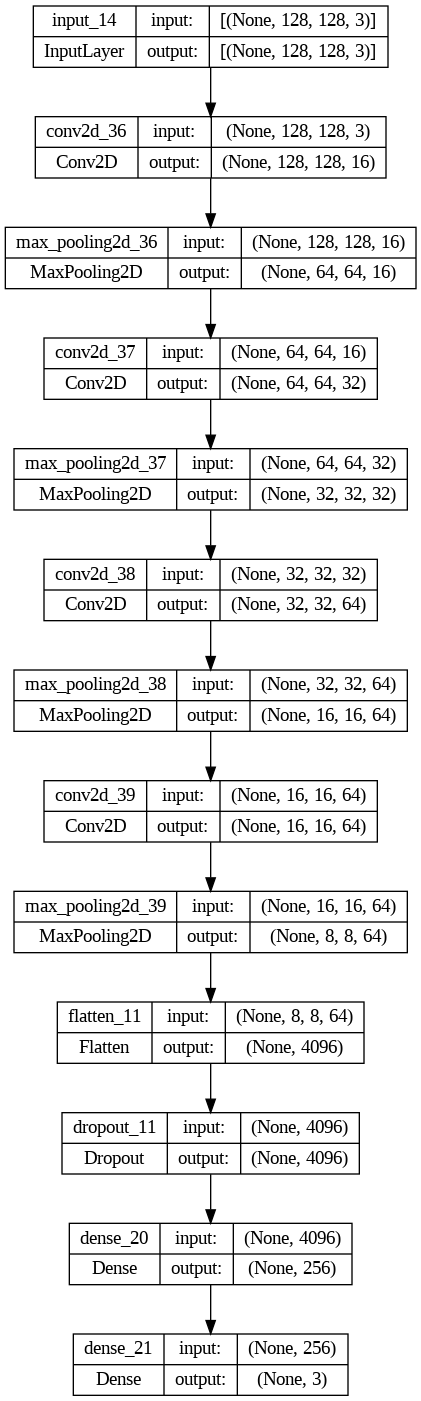

In [ ]:
from keras.utils import plot_model

plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

